In [6]:
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import cross_validate, cross_val_predict, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [7]:
#!pip install db-dtypes
#!pip install --upgrade google-cloud-bigquery google-cloud-storage google-cloud-bigquery-storage

In [8]:
import google
print(google.__file__)

None


In [9]:
# Cloud Storage
from google.cloud import storage
storage_client = storage.Client(project='film-wizard-453315')

# BigQuery
from google.cloud import bigquery
from google.cloud import bigquery_storage
print("BigQuery Storage API is installed successfully!")
bigquery_client = bigquery.Client(project='film-wizard-453315')

print("Clients initialized successfully!")

BigQuery Storage API is installed successfully!
Clients initialized successfully!


## Import Scripts

In [10]:
client = bigquery_client

query = 'SELECT * FROM `film-wizard-453315.scripts_preproc.processed_scripts_full`'
script_df = client.query(query).to_dataframe()

In [70]:
import pandas as pd

In [71]:
# project_id = 'film-wizard-453315'  # GCP Project ID
# dataset_id = "scripts_preproc"  # dataset name
# table_id = 'processed_scripts_full'  # Replace with your table name
# client = bigquery_client
# script_df.to_gbq(f"{dataset_id}.{table_id}", project_id=project_id, if_exists="replace")

In [72]:
script_df = script_df.drop_duplicates(subset=['URL']).reset_index(drop= True)
script_df.dtypes, script_df.isnull().sum()

(lower_title           object
 Title                 object
 URL                   object
 Script                object
 Clean_Script          object
 joy                  float64
 neutral              float64
 sadness              float64
 surprise             float64
 anger                float64
 disgust              float64
 fear                 float64
 sentiment_entropy    float64
 sentiment_std        float64
 hapax                  Int64
 fkgl                 float64
 fre                  float64
 smog                 float64
 fog                  float64
 word count             Int64
 TTR                  float64
 script_length          Int64
 mean_word_length     float64
 dtype: object,
 lower_title             0
 Title                   0
 URL                     0
 Script                  0
 Clean_Script            0
 joy                   927
 neutral               466
 sadness               227
 surprise              262
 anger                1152
 disgust              72

## Import TMDB


In [75]:
query = '''
SELECT title, overview, release_date, runtime, genre_1, genre_2, genre_3

FROM `film-wizard-453315.tmdb_metadata.movie_details`
'''

# Run the query and store the results in a DataFrame
tmdb_df = client.query(query).to_dataframe()

#preprocess
tmdb_df['release_year'] = tmdb_df['release_date'].astype(str).str[:4]
tmdb_df['lower_title'] = tmdb_df['title'].apply(str.lower) + ' (' + tmdb_df['release_year'] + ')'
tmdb_df['genres'] = tmdb_df['genre_1'].astype(str) + ' ' + tmdb_df['genre_2'].astype(str) + ' ' + tmdb_df['genre_3'].astype(str)
tmdb_df['genres'] = tmdb_df['genres'].str.replace('None', '').str.strip().apply(str.upper)
tmdb_df.drop(columns = ['genre_1','genre_2','genre_3','release_date'], inplace=True)
tmdb_df = tmdb_df.drop_duplicates(subset=['lower_title']).reset_index(drop= True)


tmdb_df

,title,overview,runtime,release_year,lower_title,genres
0,Ariel,A Finnish man goes to the city to find a job a...,73.0,1988,ariel (1988),COMEDY DRAMA ROMANCE
1,Shadows in Paradise,"Nikander, a rubbish collector and would-be ent...",74.0,1986,shadows in paradise (1986),COMEDY DRAMA ROMANCE
2,Four Rooms,It's Ted the Bellhop's first night on the job....,98.0,1995,four rooms (1995),COMEDY
3,Judgment Night,"Four young friends, while taking a shortcut en...",109.0,1993,judgment night (1993),ACTION CRIME THRILLER
4,Star Wars,Princess Leia is captured and held hostage by ...,121.0,1977,star wars (1977),ADVENTURE ACTION SCIENCE FICTION
...,...,...,...,...,...,...
86138,Being Romanian: A Family Journal,Being Romanian: A Family Journal is the story ...,95.0,2018,being romanian: a family journal (2018),DOCUMENTARY
86139,The Exorcists,When his child is possessed by an unrelenting ...,85.0,2023,the exorcists (2023),HORROR THRILLER
86140,The Nurse That Saw the Baby on the Highway,"Based on true/false events, nursing student Ma...",49.0,2023,the nurse that saw the baby on the highway (2023),THRILLER
86141,Beneath Us All,Julie is a foster child heading for her 18th b...,91.0,2023,beneath us all (2023),HORROR


In [76]:
tmdb_df[tmdb_df['lower_title']=='carrie fisher: wishful drinking (2010)']  #'Antarctica (2020)'

,title,overview,runtime,release_year,lower_title,genres
24025,Carrie Fisher: Wishful Drinking,"""Wishful Drinking"" is based on Fisher's memoir...",75.0,2010,carrie fisher: wishful drinking (2010),DOCUMENTARY COMEDY


In [78]:
#merge dataframes 
df = pd.merge(script_df, tmdb_df, how = 'inner', on = 'lower_title')
#df = df.drop_duplicates(subset=['lower_title'])
df['words_per_minute'] = df['script_length'] / df['runtime']
df

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,word count,TTR,script_length,mean_word_length,title,overview,runtime,release_year,genres,words_per_minute
0,voyage to the prehistoric planet (1965),Voyage to the Prehistoric Planet (1965),/movie_script.php?movie=voyage-to-the-prehisto...,"The year, 2020. The moon has been\n explored a...","[the, year, the, moon, has, been, explored, an...",0.080000,0.220000,0.080000,0.220000,0.020000,...,1128,0.226188,4987,4.207740,Voyage to the Prehistoric Planet,"In 2020, after the colonization of the moon, t...",78.0,1965,SCIENCE FICTION ADVENTURE,63.935897
1,detainment (2018),Detainment (2018),/movie_script.php?movie=detainment,1\n Jon.\n Do you know why we\n wanna talk to ...,"[jon, do, you, know, why, we, wanna, talk, to,...",NaN,0.250000,0.035714,0.071429,NaN,...,488,0.160158,3047,3.692484,Detainment,Two ten year-old boys are detained by police u...,30.0,2018,DRAMA CRIME DOCUMENTARY,101.566667
2,speak no evil (2022),Speak No Evil (2022),/movie_script.php?movie=speak-no-evil-2022,[car traveling]\n - [suspension squeaking]\n -...,"[car, traveling, suspension, squeaking, wind, ...",0.306122,0.183673,0.163265,0.142857,0.020408,...,954,0.211483,4511,4.444912,Speak No Evil,A Danish family visits a Dutch family they met...,97.0,2022,HORROR THRILLER DRAMA,46.505155
3,dossier k. (2009),Dossier K. (2009),/movie_script.php?movie=dossier-k,BLood is never unavenged\n (Art. 917 of the Ka...,"[blood, is, never, unavenged, art, of, the, ka...",0.015625,0.218750,0.078125,0.109375,0.203125,...,1358,0.212420,6393,4.168466,Dossier K.,Vincke and Verstuyft are detectives of the Ant...,120.0,2009,ACTION CRIME DRAMA,53.275
4,cyclone (1978),Cyclone (1978),/movie_script.php?movie=cyclone,(suspenseful synthwave music)\n - Now ladies a...,"[suspenseful, synthwave, music, now, ladies, a...",0.137255,0.078431,0.156863,0.039216,0.019608,...,1006,0.207166,4856,4.285420,Cyclone,An airplane goes down in the ocean during a st...,118.0,1978,HORROR,41.152542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19619,spartan (2004),Spartan (2004),/movie_script.php?movie=spartan,You had your whole life\n to prepare for this ...,"[you, had, your, whole, life, to, prepare, for...",0.037500,0.250000,0.025000,0.137500,0.112500,...,1482,0.177040,8371,3.856290,Spartan,U.S. government agent Scott is assigned to res...,102.0,2004,MYSTERY ACTION DRAMA,82.068627
19620,shadow of the wolf (1992),Shadow of the Wolf (1992),/movie_script.php?movie=shadow-of-the-wolf,AGAGUK\n (aka Shadow of the Wolf)\n GRAND NORD...,"[agaguk, aka, shadow, of, the, wolf, grand, no...",0.033333,0.033333,0.166667,0.066667,0.400000,...,622,0.190681,3262,3.693440,Shadow of the Wolf,"In the 1930s, Agaguk lives his traditional Inu...",112.0,1992,ADVENTURE,29.125
19621,bangkok dangerous (2008),Bangkok Dangerous (2008),/movie_script.php?movie=bangkok-dangerous,My job takes me to a lot of places.\n It's got...,"[my, job, takes, me, to, a, lot, of, places, i...",0.100000,0.150000,0.150000,0.100000,0.200000,...,596,0.296076,2013,3.884252,Bangkok Dangerous,"When carrying out a hit, assassin Joe always m...",99.0,2008,ACTION CRIME THRILLER,20.333333
19622,slam dance (1987),Slam Dance (1987),/movie_script.php?movie=slam-dance,Great tune. That was\n a request from my mom.....,"[great, tune, that, was, a, request, from, my,...",0.024390,0.048780,0.170732,0.463415,0.097561,...,841,0.196817,4273,3.783758,Slam Dance,"When framed for the murder of a sultry blonde,...",99.0,1987,MYSTERY THRILLER CRIME,43.161616


In [80]:
df[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']] = df[['fear', 'sadness', 'joy', 'neutral', 'anger', 'surprise', 'disgust']].fillna(0)
df[['sentiment_entropy', 'sentiment_std']] = df[['sentiment_entropy', 'sentiment_std']].fillna(df[['sentiment_entropy', 'sentiment_std']].mean())
df = df.dropna()
df = df.drop_duplicates(subset=['lower_title'])
df.isnull().sum()
df

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,word count,TTR,script_length,mean_word_length,title,overview,runtime,release_year,genres,words_per_minute
0,voyage to the prehistoric planet (1965),Voyage to the Prehistoric Planet (1965),/movie_script.php?movie=voyage-to-the-prehisto...,"The year, 2020. The moon has been\n explored a...","[the, year, the, moon, has, been, explored, an...",0.080000,0.220000,0.080000,0.220000,0.020000,...,1128,0.226188,4987,4.207740,Voyage to the Prehistoric Planet,"In 2020, after the colonization of the moon, t...",78.0,1965,SCIENCE FICTION ADVENTURE,63.935897
1,detainment (2018),Detainment (2018),/movie_script.php?movie=detainment,1\n Jon.\n Do you know why we\n wanna talk to ...,"[jon, do, you, know, why, we, wanna, talk, to,...",0.000000,0.250000,0.035714,0.071429,0.000000,...,488,0.160158,3047,3.692484,Detainment,Two ten year-old boys are detained by police u...,30.0,2018,DRAMA CRIME DOCUMENTARY,101.566667
2,speak no evil (2022),Speak No Evil (2022),/movie_script.php?movie=speak-no-evil-2022,[car traveling]\n - [suspension squeaking]\n -...,"[car, traveling, suspension, squeaking, wind, ...",0.306122,0.183673,0.163265,0.142857,0.020408,...,954,0.211483,4511,4.444912,Speak No Evil,A Danish family visits a Dutch family they met...,97.0,2022,HORROR THRILLER DRAMA,46.505155
3,dossier k. (2009),Dossier K. (2009),/movie_script.php?movie=dossier-k,BLood is never unavenged\n (Art. 917 of the Ka...,"[blood, is, never, unavenged, art, of, the, ka...",0.015625,0.218750,0.078125,0.109375,0.203125,...,1358,0.212420,6393,4.168466,Dossier K.,Vincke and Verstuyft are detectives of the Ant...,120.0,2009,ACTION CRIME DRAMA,53.275
4,cyclone (1978),Cyclone (1978),/movie_script.php?movie=cyclone,(suspenseful synthwave music)\n - Now ladies a...,"[suspenseful, synthwave, music, now, ladies, a...",0.137255,0.078431,0.156863,0.039216,0.019608,...,1006,0.207166,4856,4.285420,Cyclone,An airplane goes down in the ocean during a st...,118.0,1978,HORROR,41.152542
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19619,spartan (2004),Spartan (2004),/movie_script.php?movie=spartan,You had your whole life\n to prepare for this ...,"[you, had, your, whole, life, to, prepare, for...",0.037500,0.250000,0.025000,0.137500,0.112500,...,1482,0.177040,8371,3.856290,Spartan,U.S. government agent Scott is assigned to res...,102.0,2004,MYSTERY ACTION DRAMA,82.068627
19620,shadow of the wolf (1992),Shadow of the Wolf (1992),/movie_script.php?movie=shadow-of-the-wolf,AGAGUK\n (aka Shadow of the Wolf)\n GRAND NORD...,"[agaguk, aka, shadow, of, the, wolf, grand, no...",0.033333,0.033333,0.166667,0.066667,0.400000,...,622,0.190681,3262,3.693440,Shadow of the Wolf,"In the 1930s, Agaguk lives his traditional Inu...",112.0,1992,ADVENTURE,29.125
19621,bangkok dangerous (2008),Bangkok Dangerous (2008),/movie_script.php?movie=bangkok-dangerous,My job takes me to a lot of places.\n It's got...,"[my, job, takes, me, to, a, lot, of, places, i...",0.100000,0.150000,0.150000,0.100000,0.200000,...,596,0.296076,2013,3.884252,Bangkok Dangerous,"When carrying out a hit, assassin Joe always m...",99.0,2008,ACTION CRIME THRILLER,20.333333
19622,slam dance (1987),Slam Dance (1987),/movie_script.php?movie=slam-dance,Great tune. That was\n a request from my mom.....,"[great, tune, that, was, a, request, from, my,...",0.024390,0.048780,0.170732,0.463415,0.097561,...,841,0.196817,4273,3.783758,Slam Dance,"When framed for the murder of a sultry blonde,...",99.0,1987,MYSTERY THRILLER CRIME,43.161616


In [81]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import re  # Import regular expression module

# Download necessary NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize Stopwords, Lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Preprocessing Function
def preprocess_text(text):
    if not isinstance(text, str):  # Handle non-string values
        return ''
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Tokenize & Lowercase
    tokens = word_tokenize(text.lower())
    # Remove punctuation & stopwords
    tokens = [word for word in tokens if word not in stop_words and word not in string.punctuation]
    # Lemmatize words
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Apply preprocessing
df["clean_overview"] = df["overview"].apply(preprocess_text)

# Vectorize using CountVectorizer (Bag-of-Words Model)
count_vectorizer = CountVectorizer()
X_bow = count_vectorizer.fit_transform(df["clean_overview"])
vocab = count_vectorizer.get_feature_names_out()

# Compute word frequencies
word_counts = X_bow.toarray().sum(axis=0)  # Sum word occurrences across all rows

# Identify words appearing more than 10 times
words_to_keep = [word for word, count in zip(vocab, word_counts) if count > 100]

# Refit CountVectorizer with filtered vocabulary
filtered_vectorizer = CountVectorizer(vocabulary=words_to_keep)
X_bow_filtered = filtered_vectorizer.fit_transform(df["clean_overview"])

# Convert to DataFrame and join with the original dataframe
vectorized_texts = pd.DataFrame(
    X_bow_filtered.toarray(),
    columns=filtered_vectorizer.get_feature_names_out(),
    index=df.index
)
vectorized_texts.head()

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tigranarzumanov/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,abandoned,ability,able,accident,accidentally,accused,across,act,action,actor,...,would,writer,wrong,year,yet,york,young,younger,youth,zombie
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [82]:
from sklearn.feature_extraction.text import TfidfVectorizer
def preprocess_genres(genres):
    # Tokenize the genres (in this case, it's a simple space-separated string)
    genres = genres.lower()  # Convert to lowercase
    genres = genres.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    return ' '.join(word_tokenize(genres))  # Tokenize and rejoin into a string

df['clean_genres'] = df['genres'].apply(preprocess_genres)

# Create a TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

# Apply the vectorizer to the cleaned genres column
tfidf_matrix = vectorizer.fit_transform(df['clean_genres'])

# Convert the TF-IDF matrix to a DataFrame for easier inspection
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out()+'_genre', index = df.index)

# Display the resulting DataFrame of genre embeddings
df_combined = pd.concat([df, vectorized_texts, tfidf_df], axis=1)
df_genre_only = pd.concat([df, tfidf_df], axis=1)

In [83]:
df_genre_only

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,horror_genre,movie_genre,music_genre,mystery_genre,romance_genre,science_genre,thriller_genre,tv_genre,war_genre,western_genre
0,voyage to the prehistoric planet (1965),Voyage to the Prehistoric Planet (1965),/movie_script.php?movie=voyage-to-the-prehisto...,"The year, 2020. The moon has been\n explored a...","[the, year, the, moon, has, been, explored, an...",0.080000,0.220000,0.080000,0.220000,0.020000,...,0.000000,0.0,0.0,0.000000,0.0,0.586228,0.000000,0.0,0.0,0.0
1,detainment (2018),Detainment (2018),/movie_script.php?movie=detainment,1\n Jon.\n Do you know why we\n wanna talk to ...,"[jon, do, you, know, why, we, wanna, talk, to,...",0.000000,0.250000,0.035714,0.071429,0.000000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
2,speak no evil (2022),Speak No Evil (2022),/movie_script.php?movie=speak-no-evil-2022,[car traveling]\n - [suspension squeaking]\n -...,"[car, traveling, suspension, squeaking, wind, ...",0.306122,0.183673,0.163265,0.142857,0.020408,...,0.685028,0.0,0.0,0.000000,0.0,0.000000,0.593599,0.0,0.0,0.0
3,dossier k. (2009),Dossier K. (2009),/movie_script.php?movie=dossier-k,BLood is never unavenged\n (Art. 917 of the Ka...,"[blood, is, never, unavenged, art, of, the, ka...",0.015625,0.218750,0.078125,0.109375,0.203125,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
4,cyclone (1978),Cyclone (1978),/movie_script.php?movie=cyclone,(suspenseful synthwave music)\n - Now ladies a...,"[suspenseful, synthwave, music, now, ladies, a...",0.137255,0.078431,0.156863,0.039216,0.019608,...,1.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19619,spartan (2004),Spartan (2004),/movie_script.php?movie=spartan,You had your whole life\n to prepare for this ...,"[you, had, your, whole, life, to, prepare, for...",0.037500,0.250000,0.025000,0.137500,0.112500,...,0.000000,0.0,0.0,0.739869,0.0,0.000000,0.000000,0.0,0.0,0.0
19620,shadow of the wolf (1992),Shadow of the Wolf (1992),/movie_script.php?movie=shadow-of-the-wolf,AGAGUK\n (aka Shadow of the Wolf)\n GRAND NORD...,"[agaguk, aka, shadow, of, the, wolf, grand, no...",0.033333,0.033333,0.166667,0.066667,0.400000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0
19621,bangkok dangerous (2008),Bangkok Dangerous (2008),/movie_script.php?movie=bangkok-dangerous,My job takes me to a lot of places.\n It's got...,"[my, job, takes, me, to, a, lot, of, places, i...",0.100000,0.150000,0.150000,0.100000,0.200000,...,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.524454,0.0,0.0,0.0
19622,slam dance (1987),Slam Dance (1987),/movie_script.php?movie=slam-dance,Great tune. That was\n a request from my mom.....,"[great, tune, that, was, a, request, from, my,...",0.024390,0.048780,0.170732,0.463415,0.097561,...,0.000000,0.0,0.0,0.676135,0.0,0.000000,0.471505,0.0,0.0,0.0


In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [84]:
features = df_genre_only.drop(columns=df_combined.select_dtypes(include='object').columns)

# Standardize the features for better clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


ValueError: Input X contains infinity or a value too large for dtype('float64').

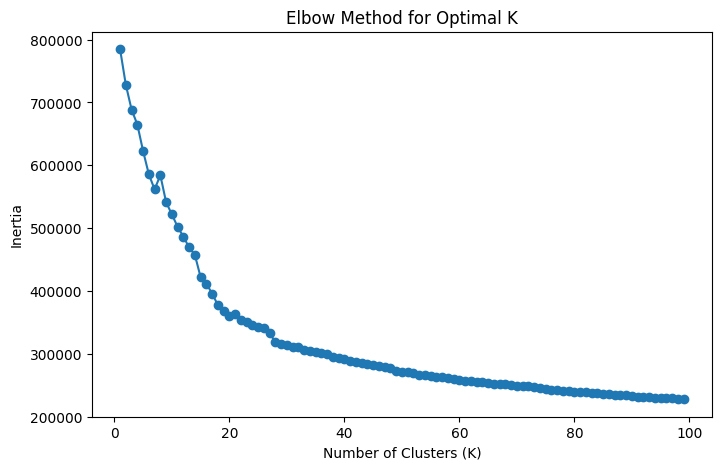

In [52]:
import matplotlib.pyplot as plt

inertia = []
K_range = range(1, 100)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=100)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8,5))
plt.plot(K_range, inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal K')
plt.show()

In [85]:
kmeans = KMeans(n_clusters=1000, random_state=42)
df_combined['Cluster'] = kmeans.fit_predict(features_scaled)

# Show sample clustered data
df_combined[['Title', 'sadness', 'joy', 'Cluster', 'comedy_genre']].head()

,Title,sadness,joy,Cluster,comedy_genre
0,Voyage to the Prehistoric Planet (1965),0.080000,0.080000,102,0.0
1,Detainment (2018),0.035714,0.000000,486,0.0
2,Speak No Evil (2022),0.163265,0.306122,960,0.0
3,Dossier K. (2009),0.078125,0.015625,756,0.0
4,Cyclone (1978),0.156863,0.137255,90,0.0


In [87]:
df_combined[df_combined['Cluster']==910]

,lower_title,Title,URL,Script,Clean_Script,joy,neutral,sadness,surprise,anger,...,movie_genre,music_genre,mystery_genre,romance_genre,science_genre,thriller_genre,tv_genre,war_genre,western_genre,Cluster
4762,flex is kings (2013),Flex Is Kings (2013),/movie_script.php?movie=flex-is-kings,"Modd!\n She went modd!\n Relax, relax, relax.....","[modd, she, went, modd, relax, relax, relax, h...",0.5,0.0,0.0,0.5,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,910


In [ ]:
script_checked = script_20.drop_duplicates(subset=['URL']).reset_index(drop= True)
script_checked